# COVID 19 Detection from chest X-Rays using a CNN Classifier

The COVID-19 pandemic has been, over the last 3 years, one of the biggest challenges for healthcare systems worldwide.

In this notebook, we will use X-ray data of lungs from both normal and COVID-positive patients and train a deep learning model to differentiate between them.

## Introduction - Dataset and models

The dataset used in this project is the Winner of the COVID-19 Dataset Award by Kaggle Community. The dataset was collected by researchers from Qatar and Bangladesh. It can be found at: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

References:
-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.[Paper link](https://ieeexplore.ieee.org/document/9144185)
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. [Paper Link](https://doi.org/10.1016/j.compbiomed.2021.104319)

This dataset contains a total of 21,215 images of 4 types:

1. COVID-19 positive (3,616 images)
1. Viral Pneumonia (1,395 images)
1. Normal X-ray (10,192 images)
1. Lung Opacity (6,012 images)

We will only consider the first three types, and therefore we'll have to classify among these 3 different classes,

The authors of the dataset also trained a ResNet-34 model and achieved a classification accuracy of 98.5%. In this notebook we'll use the **Xception** model. Xception is a deep convolutional neural network (CNN) architecture that involves [Depthwise Separable Convolutions](https://paperswithcode.com/method/depthwise-separable-convolution). This network was introduced in the paper by Francois Chollet, ["Xception: Deep Learning With Depthwise Separable Convolutions"](https://openaccess.thecvf.com/content_cvpr_2017/html/Chollet_Xception_Deep_Learning_CVPR_2017_paper.html); Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017, pp. 1251-1258 . Xception is also known as “extreme” version of an Inception module. This model obtained an ImageNet top-1 accuracy of 79% and a top-5 accuracy of 95%.

## Libraries

### timm
We will use and fine-tune a pre-trained version of the Xception model from the `timm` library ([link](https://github.com/huggingface/pytorch-image-models)). PyTorch Image Models (`timm`), a deep-learning library created by Ross Wightman, is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results. We will also use `fastai` ([link](https://docs.fast.ai/)), a deep learning library that builds on [*PyTorch*](https://pytorch.org/) and that helps simplify training neural networks by providing high-level components for standard deep learning tasks, `torchtnt`, a library for PyTorch training tools and utilities [(link)](https://pytorch.org/tnt/stable/), plus some of the usual libraries in the PyData stack: `numpy`, `pandas` and `matplotlib`.

### fast.ai
`fastai` is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches. It aims to do both things without substantial compromises in ease of use, flexibility, or performance. This is possible thanks to a carefully layered architecture, which expresses common underlying patterns of many deep learning and data processing techniques in terms of decoupled abstractions. These abstractions can be expressed concisely and clearly by leveraging the dynamism of the underlying Python language and the flexibility of the PyTorch library.

In [1]:
%pip install -Uqq torch timm fastai torchtnt torchvision

Note: you may need to restart the kernel to use updated packages.


### Import libraries

Now, we will import the necessary Python packages into our Jupyter Notebook. Here’s a brief overview of how we’ll use these packages:

1. Python Standard Library dependencies: These are built-in modules that come with Python. We’ll use them for various tasks like handling file paths ([`pathlib.Path`](https://docs.python.org/3/library/pathlib.html#pathlib.Path)), manipulating JSON files ([`json`](https://docs.python.org/3/library/json.html)), random number generation ([`random`](https://docs.python.org/3/library/random.html)), mathematical operations ([`math`](https://docs.python.org/3/library/math.html)), copying Python objects ([`copy`](https://docs.python.org/3/library/copy.html)), and working with dates and times ([`datetime`](https://docs.python.org/3/library/datetime.html)).
1. Utility functions: These are helper functions from the packages we installed earlier. They provide shortcuts for routine tasks and keep our code clean and readable.
1. matplotlib: We use the matplotlib package to explore the dataset samples and class distribution.
1. NumPy: We’ll use it to store PIL Images as arrays of pixel values.
1. pandas: We use Pandas `DataFrame` and `Series` objects to format data as tables.
1. PIL (Pillow): We’ll use it for opening and working with image files.
1. timm library: We’ll use the timm library to download and prepare a pre-trained Xception model for fine-tuning.

In [2]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
import json
import math
from pathlib import Path
import random

In [8]:
# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torchvision
import torchtnt
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from torchtnt.utils import get_module_summary

# Import fastai computer vision functionality
from fastai.vision.all import *

## Setup project

In this section, we set up some basics for our project.

### Set random seed

First, we set a seed for generating random numbers using the set_seed function included with the fastai library.
A fixed seed value is helpful when training deep-learning models for reproducibility, debugging, and comparison.
Having reproducible results allows others to confirm your findings. Using a fixed seed can make it easier to find bugs as it ensures the same inputs produce the same outputs. Likewise, using fixed seed values lets you compare performance between models and training parameters.
That said, it’s often a good idea to test different seed values to see how your model’s performance varies between them. Also, don’t use a fixed seed value when you deploy the final model.

In [4]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(False)

### Set the PyTorch Device and Data Type
Next, we determine the device to run our computations on and the data type of our tensors using fastai’s [`default_device()`](https://docs.fast.ai/torch_core.html#default_device) function.

In [9]:
device = default_device()
dtype = torch.float32

### Set directory paths

We then need to set up a directory for our project to store our results and other related files. The following code creates the folder in the current directory (./). Update the path if that is not suitable for you.

We also need a place to store our datasets and a location to download the zip file containing the dataset. Readers following the tutorial on their local machine should select locations with read and write access to store archive files and datasets. For a cloud service like Google Colab, you can set it to the current directory.

In [10]:
# A name for the project
project_name = f"covid19-classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("./Datasets/COVID-19_Radiography_Dataset")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = project_dir/'Archive/'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir, 
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,covid19-classifier
Dataset Directory:,Datasets/COVID-19_Radiography_Dataset
Archive Directory:,covid19-classifier/Archive


Double-check the project and dataset directories exist in the specified paths and that you can add files to them before continuing.

At this point, our environment is set up and ready to go. We’ve set our random seed, determined our computation device, and set up directories for our project and dataset. In the next section, we will download and explore the dataset.

## Download the dataset

The following steps demonstrate how to download the dataset from Kaggle, inspect the dataset, and visualize some sample images.
**For your convenience I've already downloaded the Dataset, and cleaned it up so it's ready to be used in this notebook. It's in the _Dataset/COVID19-Radiography-Dataset_ folder, so there's no need to execute the following cells, they are just to show how to use the opendatasets library.**

If you want to learn how to do it yourself, read on and uncomment the cells below.

To download the Kaggle dataset to the local jupyter environment we will use the [`opendatasets`](https://pypi.org/project/opendatasets/) library, so before starting, we need to have the `opendatasets` library installed in our system. If it's not present in your system, use Python’s package manager pip and run:

In [ ]:
#%pip install opendatasets

1. Import the opendatasets library

In [ ]:
#import opendatasets as od

2. Now we use the `download()` function of the `opendatasets` library, which as the name suggests, is used to download the dataset. It takes the link to the dataset as an argument.

In [ ]:
#url = "https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database"
#data_dir= "Datasets"
#od.download(url, data_dir=data_dir)

3. On executing the above line, it will prompt for your Kaggle username. Your Kaggle username can be fetched from the Account tab of the My Profile section.

4. On entering your username, it will prompt for Kaggle Key. Again, go to the account tab of the My Profile section and click on Create New API Token. This will download a kaggle.json file.

5. On opening this file, you will find the username and key in it. Copy the key and paste it into the prompted Jupyter Notebook cell. The content of the downloaded file would look like this:

`{"username":<KAGGLE USERNAME>,"key":"<KAGGLE KEY>"}`

6. Do NOT store the API Token (kaggle.json file) in your GitHub repository.

7. A progress bar will show if the dataset is downloaded completely or not.

8. After successful completion of the download, a folder will be created in the Datasets directory of your Jupyter Notebook. This folder contains our dataset.

9. Since we will not be using any of the metadata info nor the Lung Opacity images, delete that subdirectory. This will also make loading the dataset much easier (no need to filter out sub-directories when building the training and evaluation sets).

Alternatively, you can just run the cell below to unzip the compressed dataset which I've already prepared.

In [ ]:
!unzip -q COVID19_Radiography_Dataset.zip -d ./Datasets

### Get dataset information

In [11]:
# Set the name of the dataset
dataset_name = 'COVID19-Chest-XRay'

dataset_path = Path(dataset_dir)
# Get the file paths for each image in the dataset
img_paths = get_image_files(dataset_path)

In [12]:
# Get the number of samples for each image class
class_counts = Counter(path.parent.name for path in img_paths)

# Get the class names
class_names = list(class_counts.keys())

# Print the number of samples for each image class
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
class_counts_df

,Count
COVID,3616
Viral_Pneumonia,1345
Normal,10192


### Visualizing Sample Images

Lastly, we will visualize a sample image from each class in our dataset. Visualizing the samples helps us get a feel for the kind of images we’re working with and whether they’re suitable for the task at hand.

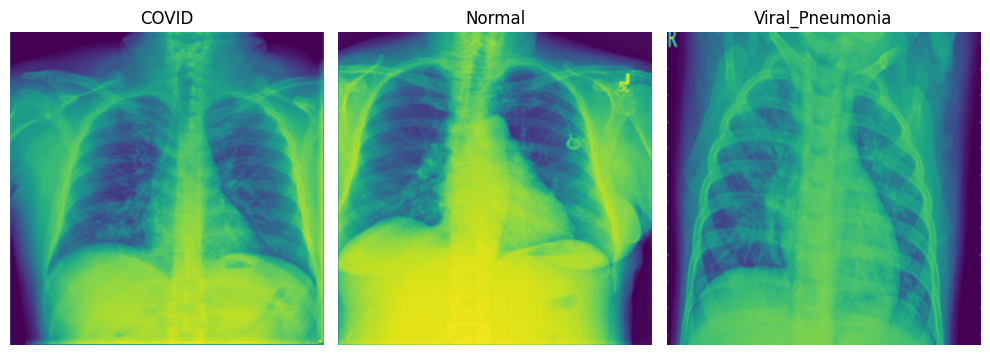

In [13]:
# Get paths for the first sample in the dataset for each class
sample_paths = [next((dataset_path/class_name).iterdir()) for class_name in class_names]
sample_paths.sort()

# Set the number of rows and columns
n_rows = 1
n_cols = 3

# Create a list to store the first image found for each class
images = [Image.open(path) for path in sample_paths]
labels = [path.parent.name for path in sample_paths]

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(images) and images[i]:
        # Add the image to the subplot
        ax.imshow(np.array(images[i]))
        # Set the title to the corresponding class name
        ax.set_title(labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Select model

Choosing a suitable model for your task is crucial for the success of your machine learning project. The model you select will depend on several factors, including the size and nature of your dataset, the problem you’re trying to solve, and the computational resources you have at your disposal.

### The timm library - Exploring Available Models

One of the most popular features of `timm` is its large, and ever-growing collection of model architectures. Many of these models contain pretrained weights — either trained natively in PyTorch, or ported from other libraries such as Jax and TensorFlow — which can be easily downloaded and used. We can list, and query, the collection available models as demonstrated below:

In [14]:
len(timm.list_models('*'))

1007

We can also use the `pretrained` argument to filter this selection to the models with pretrained weights:

In [15]:
len(timm.list_models(pretrained=True))

1260

The library has hundreds of models, so a proper selection of a model for image classification tasks should take into account considerations of accuracy and speed. Selecting an adequate model for our task at hand is a topic that deserved its own notebook. We'll proceed here with the abovementioned decision: the Xception model. We start by inspecting the various pre-trained Xception models found in `timm`.

In [16]:
pd.DataFrame(timm.list_models('xception*', pretrained=True))

,0
0,xception41.tf_in1k
1,xception41p.ra3_in1k
2,xception65.ra3_in1k
3,xception65.tf_in1k
4,xception65p.ra3_in1k
5,xception71.tf_in1k


We'll select the `xception65.ra3_in1k` as our baseline model. Its Hugging Face model card is [here](https://huggingface.co/timm/xception65.ra3_in1k).

### Inspect the model configuration

Next, we will inspect the configuration of our chosen model. The model config gives us information about the pretraining process for the model.

In [17]:
# Import the xception module
from timm.models import xception

# Define the Xception model variant to use
xception_model = 'xception65.ra3_in1k'

# Get the default configuration of the chosen model
model_cfg = timm.data.resolve_model_data_config(xception_model)

# Show the default configuration values
pd.DataFrame({"Prop. name": model_cfg.keys(), "Prop. value": model_cfg.values()})

,Prop. name,Prop. value
0,input_size,"(3, 224, 224)"
1,interpolation,bicubic
2,mean,"(0.485, 0.456, 0.406)"
3,std,"(0.229, 0.224, 0.225)"
4,crop_pct,0.875
5,crop_mode,center


### Loading the Model

We can now load our model. We’ll set the number of output classes equal to the number of image classes in our dataset. We’ll also specify the device and data type for the model.

In [19]:
# Create a pretrained Xception model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
xception65 = timm.create_model(xception_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
xception65 = xception65.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
xception65.device = device
xception65.name = xception_model

# Assign the model
model = xception65

### Summarizing the Model

Finally, let’s generate a summary of our model. The summary gives us an overview of its structure and performance characteristics.

In [20]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
def mkdwn_to_pnds(md_table_str:str):
    # Split the input markdown string into separate lines
    lines = md_table_str.strip().split("\n")

    # Split the first line of the input markdown string into columns
    columns = lines[0].split("|")[1:-1]

    # Strip the whitespaces in the columns
    columns = [x.strip() for x in columns]

    # Split the remaining lines of the input markdown string into rows of data
    data = [line.split("|")[1:-1] for line in lines[2:]]

    # Strip the whitespaces in each row of data
    data = [[x.strip() for x in row] for row in data]

    # Create a pandas DataFrame from the columns and data
    pd.DataFrame(data, columns=columns)
    
    # Create a pandas DataFrame from the columns and data
    return pd.DataFrame(data, columns=columns)

summary_df = mkdwn_to_pnds(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,XceptionAligned,37.9 M,37.9 M,152 M,9.8 G,98.4 G,"[1, 3, 256, 256]","[1, 3]"
3,Conv2d,864,864,3.5 K,14.2 M,14.2 M,"[1, 3, 256, 256]","[1, 32, 128, 128]"
8,Conv2d,18.4 K,18.4 K,73.7 K,301 M,603 M,"[1, 32, 128, 128]","[1, 64, 128, 128]"
15,Conv2d,8.2 K,8.2 K,32.8 K,33.6 M,67.1 M,"[1, 64, 128, 128]","[1, 128, 64, 64]"
22,Conv2d,576,576,2.3 K,9.4 M,613 M,"[1, 64, 128, 128]","[1, 64, 128, 128]"
25,Conv2d,8.2 K,8.2 K,32.8 K,134 M,268 M,"[1, 64, 128, 128]","[1, 128, 128, 128]"
30,Conv2d,1.2 K,1.2 K,4.6 K,18.9 M,2.4 G,"[1, 128, 128, 128]","[1, 128, 128, 128]"
33,Conv2d,16.4 K,16.4 K,65.5 K,268 M,536 M,"[1, 128, 128, 128]","[1, 128, 128, 128]"
38,Conv2d,1.2 K,1.2 K,4.6 K,4.7 M,608 M,"[1, 128, 128, 128]","[1, 128, 64, 64]"
41,Conv2d,16.4 K,16.4 K,65.5 K,67.1 M,134 M,"[1, 128, 64, 64]","[1, 128, 64, 64]"


We can see from the summary that the `xception65.ra3_in1k` model is about 150 MB in size and needs to perform about 9.8 billion floating-point operations to process a single 256x256 input image.

That is valuable information when considering how we will deploy the fine-tuned model. For example, the number of floating-point operations will influence what hardware can run the model smoothly. For real-time applications, even milliseconds can matter for inference speed. Inference involves making predictions with a trained model on new, unseen data.

The model architecture also influences inference speed beyond the raw number of floating-point operations. A smaller, less demanding model would be required to run inference in mobile phone CPUs, while the Xception architectures can better leverage larger GPUs.

That completes the model selection and setup. In the next section, we will prepare our dataset for training.

## Preparing the Data

Next, we will prepare our data for the model training process. The data preparation involves several steps, such as applying data augmentation techniques, resizing and padding the images, and initializing `DataLoaders` to feed data to the model.

### Data Augmentation

We will now define what data augmentations to apply to images during training. Data augmentation is a technique that effectively expands the size and diversity of a dataset by creating variations of existing samples. It helps the model learn general features instead of memorizing specific examples.

A very important consideration: example ways to perform data augmentation for images include rotating the image by a few degrees or sliding it left, right, up, or down a few pixels. Depending on the specific image "anatomy", flipping an image horizontally or vertically might create new versions that are useful for training, but in other cases, flipping an image vertically would be nonsense. For example, an upside-down chest radiograph would not be useful; flipping a chest radiograph horizontally (left-right) would likely make it impossible to diagnose situs inversus. 
In most cases of medical imaging, we have very few examples, and using data augmentation to create these variations is extremely useful to promote generalization. However, it is critical that only sensible augmentations be performed. In some cases, altering intensity may be feasible (e.g. MRI) while for others, the absolute intensity value has specific meaning (e.g. CT or parametric images). 

Because fastai is designed primarily for photographic images, the types of transforms that make sense for photographs may not be appropriate for medical images. Thus, we need to carefully design our data augmentation pipeline.

We'll take advantage of fastai's [image augmentation capabilities]((https://docs.fast.ai/vision.html#Data-augmentation), and run the following transformations:
1. rotation between -30° and 30°
1. zoom between 1 and 1.2

In [21]:
# Define custom transform
custom_aug = [Rotate(max_deg=30), Zoom(max_zoom=1.2)]          

### Normalization

Before we can use the Xception model, we need to normalize our dataset. Normalization is a process that changes the range of pixel intensity values to make the neural network converge faster during training. It is performed by subtracting the mean from the pixel values and dividing by the standard deviation of the dataset. The mean and standard deviation values specific to the dataset used in the pretraining process of our model are called normalization statistics. To do this, we will retrieve the normalization statistics (mean and std) specific to our pretrained model.

In [22]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

,0,1,2
0,0.485,0.456,0.406
1,0.229,0.224,0.225


In [23]:
# Convert normalization stats to tensors
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1).to(device)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1).to(device)

### Item and Batch Transforms

Now, we can define what transforms to apply to individual images and batches of tensors. We will apply the data augmentation to individual images and normalize input in batches.

In [24]:
# Define the transformations to apply to individual images
item_tfms = [Resize((224), method='squish')]

# Convert normalization stats to tensors
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1).to(device)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1).to(device)

# Define the transforms to apply to batches
batch_tfms = [*custom_aug, Normalize(mean=mean_tensor, std=std_tensor)]

### Training Batch Size

Next, we set the batch size for training. This number indicates how many sample images get fed to the model at once. The larger the batch size, the more GPU memory we need. The current batch size should be fine for most modern GPUs. If you still get an out-of-memory error, try lowering the batch size to 8, then restart the Jupyter Notebook.

In [25]:
batch_sz = 32

### Initialize DataLoaders

fastai makes it easy to initialize the `DataLoaders` for an image dataset from a single function call, such as `ImageDataLoaders.from_folder()`.

fastai will automatically split the dataset samples into training and validation sets based on the percentage we specify. The model will use the training set to update its parameters, and we will use the validation set to evaluate model performance on data it has not seen before.

Validation sets are needed when training models because we want to verify the model can generalize well to new data before we deploy it. Since we want to see how the model performs on regular images instead of augmented ones, we will remove the trivial augmentation transform from the validation `DataLoader` object.

In [26]:
dls = ImageDataLoaders.from_folder(
    path=dataset_path,    # The path to the root folder containing the images.
    valid_pct=0.1,        # The percentage of the images to use for validation
    bs=batch_sz,          # The number of samples to process in a single pass through the model
    item_tfms=item_tfms,  # A list of transformations to apply to each individual image.
    batch_tfms=batch_tfms # A list of transformations to apply to each batch of tensors
)

In [27]:
# Remove the augmentation for validation
dls.valid.after_item = Pipeline([ToTensor])

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(dls.train),
    'Number of batches in validation DataLoader:': len(dls.valid)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,426
Number of batches in validation DataLoader:,48


Before we move on, let’s verify the `DataLoaders` are applying the transforms as intended.

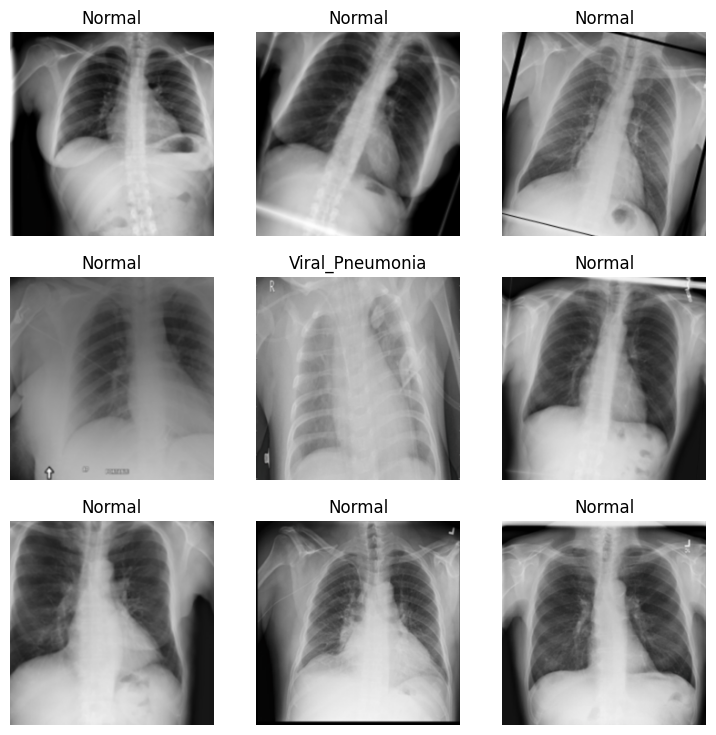

In [28]:
dls.train.show_batch()

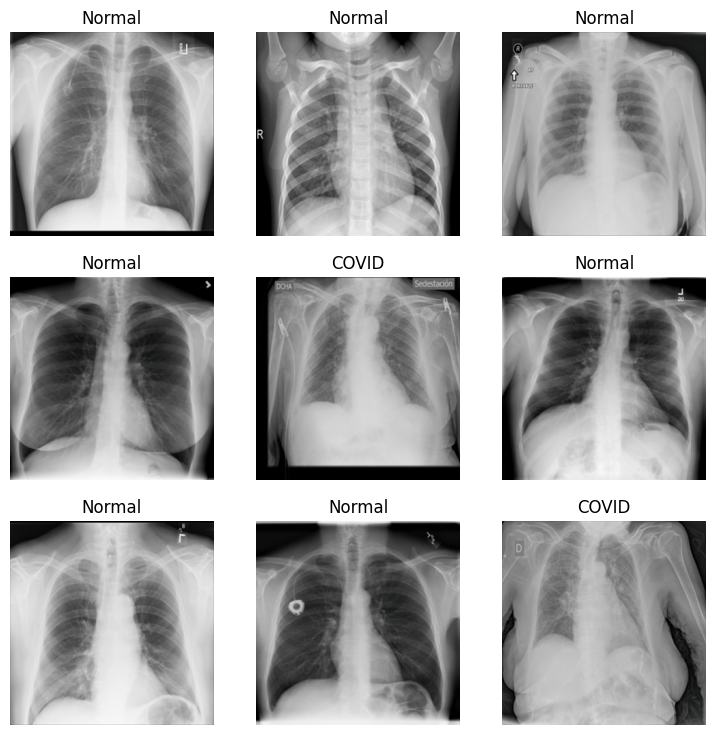

In [29]:
dls.valid.show_batch()

From the above samples, we can see the training `DataLoader` is indeed applying the custom augmentations and resizing/padding the images to squares. Meanwhile, the validation `DataLoader` only resizes and pads the samples.

That completes the data preparation. Now, we can finally train our model.

## Fine-tune the model

### Set the Model Checkpoint Path

Before we proceed with training, we will generate a timestamp for the training session and create a directory to store a checkpoint for the fine-tuned model. That enables us to load the model later to resume training, export the model to a different format, or perform inference directly.

In [96]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

covid19-classifier/2023-10-28_11-12-42/xception65.ra3_in1k.pth


We will also save a copy of the normalization stats and the class labels for the current dataset in the training folder for future use.

### Save the normalization stats

In [97]:
# Convert tuples to dictionaries for easier JSON representation
norm_stats_dict = {"mean": norm_stats[0], "std_dev": norm_stats[1]}

# Export to JSON
with open(f"{checkpoint_dir}/norm_stats.json", "w") as f:
    json.dump(norm_stats_dict, f)

# Print the name of the file that the normalization stats were written to
print(f"{checkpoint_dir}/norm_stats.json")

covid19-classifier/2023-10-28_11-12-42/norm_stats.json


### Save the class labels

In [98]:
# Save class labels
class_labels = {"classes": list(dls.vocab)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)
    
print(class_labels_path)

covid19-classifier/2023-10-28_11-12-42/COVID19-Chest-XRay-classes.json


### Initialize the Fastai learner

fastai uses a `Learner` object to facilitate the training process. A `Learner` object groups the model, `DataLoaders`, and a loss function to handle training.

Loss refers to a number representing how far model predictions are from the actual values. The loss value influences how the model parameters change to learn the desired task. The goal of training is to minimize this value.

The `Learner` object also allows us to specify what performance metrics we want to help us gauge model performance during training.

In [99]:
learn = Learner(dls, model, metrics=[error_rate, accuracy], model_dir=checkpoint_dir.absolute())

### Find a suitable learning rate

We use a learning rate value to limit how much the model parameters change based on the loss value after each batch. Using a learning rate that is either too big or too small will prevent the model from reaching its ideal performance potential.

Finding a suitable learning rate value can require experimentation based on the model and dataset. Fortunately, fastai provides `lr_find()` a method in the `Learner` class that automates finding a reasonable value. It increases the learning rate in a mock training session and tracks how the different values influence the loss. It then suggests a learning rate based on its findings.

'Learning Rate: 2.075492920994293e-05'

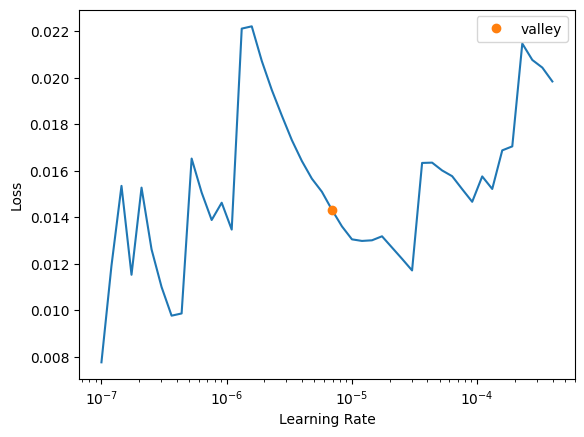

In [100]:
suggested_lrs = learn.lr_find()
lr = suggested_lrs.valley*3
f"Learning Rate: {lr}"

### Train the model

The training process revolves around the concept of an **epoch**. Each epoch represents one complete pass through the entire training and validation sets. A `Learner` object handles iterating through the training and validation sets and feeding batches to the model.

For each batch of data, it performs a forward pass (calculating the predictions of the model), computes the loss, and then, if in training mode, performs a backward pass to adjust the model parameters.

We also have the option to use mixed precision training. Mixed-precision training involves performing some operations in 16-bit precision to speed up training and reduce memory requirements. Modern GPUs tend to have specialized hardware to accelerate these lower-precision operations, and this feature allows us to utilize that.

Training time will depend on the available hardware. Feel free to take a break if the progress bar indicates it will take a while.

In [101]:
learn.fine_tune(epochs=4, base_lr=lr, cbs=[MixedPrecision()])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.018402,nan,0.062706,0.937294,01:22


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.013258,nan,0.056766,0.943234,01:22
1,0.013282,nan,0.054785,0.945215,01:22
2,0.015971,nan,0.060066,0.939934,01:22
3,0.009964,nan,0.054125,0.945875,01:22


We have a first version of our COVID-19 detector. The readout for the final epoch indicates the model achieved over 94.5% accuracy, meaning it missed less than 6% of the 1,515 samples in the validation set.

We can take a more detailed look at how our model is performing by creating a [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix), also known as an Error Matrix: each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another). 

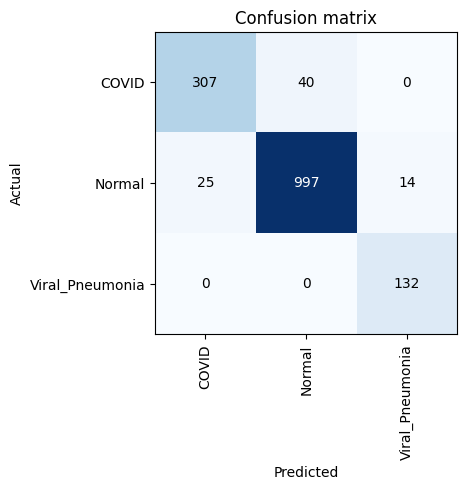

In [107]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

As mentioned above, we can export our Learner object to a file for future use. We can also save the model checkpoint separately if we want to use the model without needing fastai.

### Save the learner

In [105]:
learn.export(checkpoint_dir.absolute()/f"{model.name}.pkl")

### Save the model checkpoint

In [106]:
torch.save(learn.model.state_dict(), checkpoint_path)